In [1]:
from collections import defaultdict

import numpy as np
import pandas as pd

prices = []
trades = []

last_timestamp = -100
for day in range(-2, 1):
    p = pd.read_csv(f'../../data/prices_round_1_day_{day}.csv', sep=';')
    p['timestamp'] = p['timestamp'] + last_timestamp + 100
    prices.append(p)
    
    t = pd.read_csv(f'../../data/trades_round_1_day_{day}_nn.csv', sep=';')
    t['timestamp'] = t['timestamp'] + last_timestamp + 100
    trades.append(t)

    last_timestamp = np.max(p['timestamp'])

prices = pd.concat(prices, axis=0, ignore_index=True)
trades = pd.concat(trades, axis=0, ignore_index=True)

In [9]:
prices.head()

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,-2,0,AMETHYSTS,9996,1,9995.0,25.0,NaN,NaN,10004,1,10005.0,25.0,NaN,NaN,10000.0,0.0
1,-2,0,STARFRUIT,4997,26,NaN,NaN,NaN,NaN,5003,26,NaN,NaN,NaN,NaN,5000.0,0.0
2,-2,100,AMETHYSTS,10000,5,9995.0,20.0,NaN,NaN,10005,20,NaN,NaN,NaN,NaN,10002.5,0.0
3,-2,100,STARFRUIT,5000,5,4998.0,6.0,4997.0,20.0,5004,20,NaN,NaN,NaN,NaN,5002.0,0.0
4,-2,200,STARFRUIT,4997,1,4996.0,30.0,NaN,NaN,5003,31,NaN,NaN,NaN,NaN,5000.0,0.0


In [6]:
trades.head()

,timestamp,buyer,seller,symbol,currency,price,quantity
0,0,NaN,NaN,AMETHYSTS,SEASHELLS,9996.0,1
1,0,NaN,NaN,STARFRUIT,SEASHELLS,5003.0,1
2,0,NaN,NaN,AMETHYSTS,SEASHELLS,9996.0,1
3,100,NaN,NaN,STARFRUIT,SEASHELLS,5004.0,6
4,900,NaN,NaN,STARFRUIT,SEASHELLS,5001.0,2


### Trades spread analysis

In [3]:
spread_dist = defaultdict(lambda: defaultdict(int))

for price in prices.iterrows():
    for trade in trades[(trades['timestamp'] == price[1]['timestamp']) & (trades['symbol'] == price[1]['product'])].iterrows():
        spread_dist[price[1]['product']][trade[1]['price'] - price[1]['omp']] += trade[1]['quantity']

AttributeError: 'Axes' object has no attribute 'xlabel'

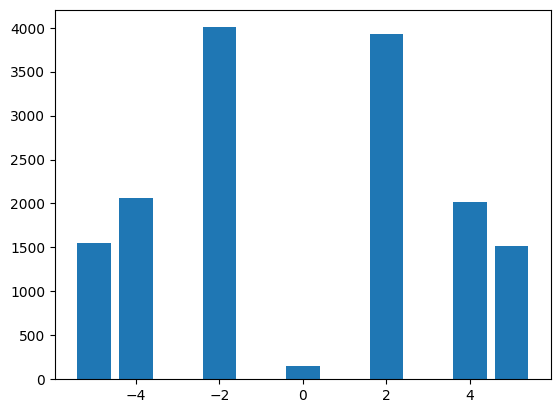

In [4]:
import matplotlib.pyplot as plt

def plot_histogram(dictionary):
    # Sort the dictionary by keys
    fig = plt.figure()
    ax = fig.add_subplot()
    sorted_dict = sorted(dictionary.items())

    # Extract keys and values
    keys = [item[0] for item in sorted_dict]
    values = [item[1] for item in sorted_dict]

    # Plot histogram
    ax.bar(keys, values)
    ax.xlabel('Spread')
    ax.ylabel('Trades')
    plt.show()

plot_histogram(spread_dist['AMETHYSTS'])

AttributeError: 'Axes' object has no attribute 'xlabel'

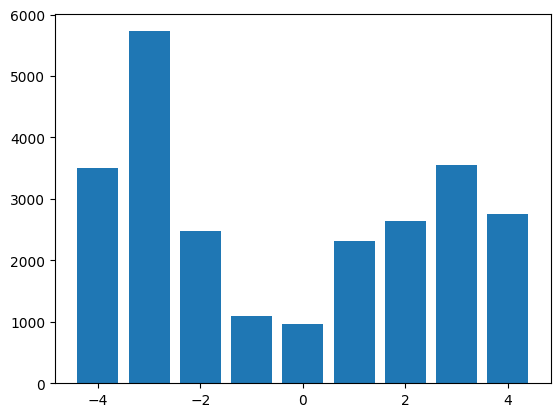

In [5]:
plot_histogram(spread_dist['STARFRUIT'])

In [6]:
sum(spread_dist['AMETHYSTS'].values()), sum(spread_dist['STARFRUIT'].values())

(15227, 24996)

In [7]:
sorted_dict = sorted(spread_dist['AMETHYSTS'].items())
s = 0
values = []
for item in sorted_dict:
    s += item[1]
    values.append(s / sum([item[1] for item in sorted_dict]))

values

[0.10205555920404545,
 0.23734156432652526,
 0.23760425559860773,
 0.5006238917711959,
 0.5102121232022067,
 0.7683719708412688,
 0.9007026991528206,
 1.0]

### Fair price estimations

In [2]:
import statistics as stat

def vwap(row):
    return stat.fmean([row[f'ask_price_{i}'] for i in range(1, 4)], weights=[row[f'ask_volume_{i}'] for i in range(1, 4)])

def vwbp(row):
    return stat.fmean([row[f'bid_price_{i}'] for i in range(1, 4)], weights=[row[f'bid_volume_{i}'] for i in range(1, 4)])

def vwmp(row):
    return (vwap(row) + vwbp(row)) / 2

def biggest_mid_price(row):
    ask_vols = [row[f'ask_volume_{i}'] for i in range(1, 4)]
    mid = [row[f'ask_price_{i}'] for i in range(1, 4)][ask_vols.index(max(ask_vols))]
    bid_vols = [row[f'bid_volume_{i}'] for i in range(1, 4)]
    mid += [row[f'bid_price_{i}'] for i in range(1, 4)][bid_vols.index(max(bid_vols))]
    return mid / 2

def outer_mid_price(row):
    asks = [row['ask_price_3'], row['ask_price_2'], row['ask_price_1']]
    bids = [row['bid_price_3'], row['bid_price_2'], row['bid_price_1']]

    mid = 0

    for ask in asks:
        if not np.isnan(ask):
            mid += ask
            break

    for bid in bids:
        if not np.isnan(bid):
            mid += bid
            break

    return np.rint(mid / 2)


pricesnan = prices.fillna(0)
prices['vwmp'] = pricesnan.apply(vwmp, axis=1)
prices['vwap'] = pricesnan.apply(vwap, axis=1)
prices['vwbp'] = pricesnan.apply(vwbp, axis=1)
prices['vol'] = prices['ask_volume_1'] + prices['ask_volume_2'] + prices['ask_volume_3'] - (prices['bid_volume_1'] + prices['bid_volume_2'] + prices['bid_volume_3'])
prices['omp'] = prices.apply(outer_mid_price, axis=1)
prices['bmp'] = prices.apply(biggest_mid_price, axis=1)

In [19]:
prices.head()

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,...,ask_price_3,ask_volume_3,mid_price,profit_and_loss,vwbp,omp,vwmp,vwap,vol,bmp
0,-2,0,AMETHYSTS,9996,1,9995.0,25.0,NaN,NaN,10004,...,NaN,NaN,10000.0,0.0,9995.038462,10000.0,10000.000000,10004.961538,NaN,10000.0
1,-2,0,STARFRUIT,4997,26,NaN,NaN,NaN,NaN,5003,...,NaN,NaN,5000.0,0.0,4997.000000,5000.0,5000.000000,5003.000000,NaN,5000.0
2,-2,100,AMETHYSTS,10000,5,9995.0,20.0,NaN,NaN,10005,...,NaN,NaN,10002.5,0.0,9996.000000,10000.0,10000.500000,10005.000000,NaN,10000.0
3,-2,100,STARFRUIT,5000,5,4998.0,6.0,4997.0,20.0,5004,...,NaN,NaN,5002.0,0.0,4997.677419,5000.5,5000.838710,5004.000000,NaN,5000.5
4,-2,200,STARFRUIT,4997,1,4996.0,30.0,NaN,NaN,5003,...,NaN,NaN,5000.0,0.0,4996.032258,4999.5,4999.516129,5003.000000,NaN,4999.5


In [30]:
%matplotlib notebook
prices[prices['product'] == 'AMETHYSTS'].plot(y=['omp'], style='-')
prices[prices['product'] == 'STARFRUIT'].plot(y=['bmp', 'omp', 'vwmp'], style='-')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Axes: >